# **NLP for Multiclass Movie Genre Classification**
by : Bayu Alansyah

## **Download Dataset** 
Dataset from Kaggle : [movie genre data](https://www.kaggle.com/lokkagle/movie-genre-data)

In [1]:
# install kaggle package
!pip install -q kaggle

In [2]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"bayualansyah","key":"84568f08a91b86b7684c67d48c8366ed"}'}

In [3]:
# make directory and change permission
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle/json
!ls ~/.kaggle

chmod: cannot access '/root/.kaggle/kaggle/json': No such file or directory
kaggle.json


In [4]:
# test kaggle dataset list
!kaggle datasets list

ref                                                           title                                              size  lastUpdated          downloadCount  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                   Reddit Vaccine Myths                              233KB  2021-07-06 12:04:44           8851  
crowww/a-large-scale-fish-dataset                             A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5425  
imsparsh/musicnet-dataset                                     MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1943  
dhruvildave/wikibooks-dataset                                 Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2355  
promptcloud/careerbuilder-job-listing-2020                    Ca

In [5]:
# download dataset, choose 'copy api command' from kaggle dataset
!kaggle datasets download -d lokkagle/movie-genre-data

movie-genre-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# unzip
!mkdir movie-genre-data
!unzip movie-genre-data.zip -d movie-genre-data
!ls movie-genre-data

mkdir: cannot create directory ‘movie-genre-data’: File exists
Archive:  movie-genre-data.zip
replace movie-genre-data/kaggle_movie_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: movie-genre-data/kaggle_movie_train.csv  
kaggle_movie_train.csv


## Load Dataset

In [7]:
# import library
import pandas as pd
import re
from sklearn.model_selection import train_test_split

In [8]:
# load dataset
df = pd.read_csv('movie-genre-data/kaggle_movie_train.csv')
df.head(10)

,id,text,genre
0,0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,2,"t, summa cum laude and all. And I'm about to l...",comedy
2,3,"up Come, I have a surprise.... She takes him ...",drama
3,4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,5,"nd dismounts, just as the other children reach...",drama
5,6,breadth of the bluff. Gabe pulls out his ancie...,thriller
6,7,uilding. A MAN in pajamas runs out into the ra...,thriller
7,9,ELLES AND RITA HAYWORTH Just disgustingly rich...,drama
8,10,"Memphis goes back into the garage, Budgy cack...",thriller
9,11,e reels as the world spins. Sweat pours off hi...,action


In [9]:
# data columns
df.columns

Index(['id', 'text', 'genre'], dtype='object')

In [10]:
# total data
df.shape

(22579, 3)

In [11]:
# data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22579 entries, 0 to 22578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      22579 non-null  int64 
 1   text    22579 non-null  object
 2   genre   22579 non-null  object
dtypes: int64(1), object(2)
memory usage: 529.3+ KB


In [12]:
# check total value of each genre
df.genre.value_counts()

drama        8873
thriller     6824
comedy       2941
action       2392
sci-fi        613
horror        456
other         270
adventure     147
romance        63
Name: genre, dtype: int64

## Preprocessing Data

Only 4 genres are used on this occasion : `comedy`,`action`,`sci-fi`,`horror`.

In [13]:
# Deleting genres other than those 4 genres
df = df[~df['genre'].isin(['drama','thriller','other','adventure','romance'
])]
df.genre.value_counts()

comedy    2941
action    2392
sci-fi     613
horror     456
Name: genre, dtype: int64

Deleting special characters in columns Text

In [14]:
# Deleting special characters in columns Text
df['Text'] = df['text'].map(lambda x: re.sub(r'\W+', ' ', x))

# Drop columns Id and old Text 
df = df.drop(['id', 'text'], axis=1)
df.head()

,genre,Text
1,comedy,t summa cum laude and all And I m about to lau...
9,action,e reels as the world spins Sweat pours off him...
20,comedy,I say he s a man who ll go far Some people sa...
25,comedy,you find out where the bachelor party is COLE ...
29,comedy,ibly horrendous public break up on the quad Ag...


Check NA 

In [15]:
# If it is true then there is and if it is false then there is no NA value
df.isnull().values.any()

False

Genre labeling

In [16]:
genre = pd.get_dummies(df.genre)
df_genre = pd.concat([df, genre], axis=1)
df_genre = df_genre.drop(columns='genre')
df_genre.head()

,Text,action,comedy,horror,sci-fi
1,t summa cum laude and all And I m about to lau...,0,1,0,0
9,e reels as the world spins Sweat pours off him...,1,0,0,0
20,I say he s a man who ll go far Some people sa...,0,1,0,0
25,you find out where the bachelor party is COLE ...,0,1,0,0
29,ibly horrendous public break up on the quad Ag...,0,1,0,0


Changes data type

In [17]:
# Change the data type to str and numpy array
text = df_genre['Text'].astype(str)
label = df_genre[['action','comedy','horror','sci-fi']].values

Split dataset 20% test/validation

In [18]:
from sklearn.model_selection import train_test_split
genre_train, genre_test, label_train, label_test = train_test_split(text, label, test_size=0.2)


Use of tokenizer

In [19]:
# Convert to sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(genre_train)
tokenizer.fit_on_texts(genre_test)

sekuens_train = tokenizer.texts_to_sequences(genre_train)
sekuens_test = tokenizer.texts_to_sequences(genre_test)

padded_train = pad_sequences(sekuens_train)
padded_test = pad_sequences(sekuens_test)

## **Model and Plot**

Sequential Modeling with Embedding and LSTM

In [20]:
# Modeling
import tensorflow as tf

model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4, activation='softmax') 
])

Compile model with Adam optimizer

In [21]:
from tensorflow.keras.optimizers import Adam
Adam(learning_rate=0.00146, name='Adam')

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Use Callback for accuracy and validation above 90%

In [22]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nTrain and validation accuracy obtained has reached a value of > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

Training Model

In [23]:
num_epochs = 30
history = model.fit(padded_train, label_train, epochs=num_epochs,
                    validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/30
161/161 - 24s - loss: 1.1334 - accuracy: 0.4610 - val_loss: 0.9770 - val_accuracy: 0.5004
Epoch 2/30
161/161 - 21s - loss: 0.7033 - accuracy: 0.7194 - val_loss: 0.6390 - val_accuracy: 0.7603
Epoch 3/30
161/161 - 21s - loss: 0.4136 - accuracy: 0.8385 - val_loss: 0.7306 - val_accuracy: 0.7541
Epoch 4/30
161/161 - 21s - loss: 0.2571 - accuracy: 0.8865 - val_loss: 0.4253 - val_accuracy: 0.8267
Epoch 5/30
161/161 - 22s - loss: 0.2466 - accuracy: 0.8901 - val_loss: 0.6072 - val_accuracy: 0.7994
Epoch 6/30
161/161 - 22s - loss: 0.1699 - accuracy: 0.9147 - val_loss: 0.4304 - val_accuracy: 0.8525
Epoch 7/30
161/161 - 22s - loss: 0.1422 - accuracy: 0.9233 - val_loss: 0.4099 - val_accuracy: 0.8626
Epoch 8/30
161/161 - 22s - loss: 0.1323 - accuracy: 0.9287 - val_loss: 0.4314 - val_accuracy: 0.8657
Epoch 9/30
161/161 - 21s - loss: 0.1291 - accuracy: 0.9352 - val_loss: 0.6217 - val_accuracy: 0.8478
Epoch 10/30
161/161 - 21s - loss: 0.1134 - accuracy: 0.9559 - val_loss: 0.6033 - val_accura

Making plot accuracy and loss

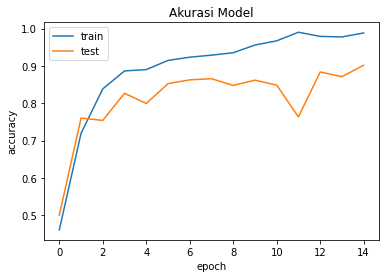

In [24]:
import matplotlib.pyplot as plt
# Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

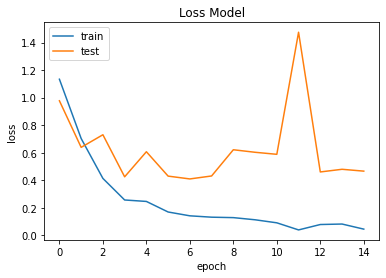

In [25]:
# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()